В данном упражнении вам предстоит решить уже знакомую задачу классификации изображений – отделить изображения кошек от изображений собак, используя ансамбль моделей на основе стекинга.

В предложенном архиве находится выборка, включающая в себя изображения кошек и собак (по 500 изображений). Имя каждого изображения, для удобства, имеет следующий формат: cat/dog.номер_изображения.jpg в зависимости от того, какое животное присутствует на изображении. Данная выборка используется для обучения классификатора и его оценки.
Следующая выборка предназначена для классификации новых объектов после построения классификатора.
Обучите базовые алгоритмы на исходном наборе данных:

Классификатор с мягким зазором и параметрами: C = 1.25, random_state = 80, остальные параметры по умолчанию;
Бэггинг деревьев принятия решений. Параметры дерева: criterion = 'entropy', min_samples_leaf = 10, max_leaf_nodes = 20, random_state = 80, остальные параметры по умолчанию. Параметры бэггинга: n_estimators = 13, random_state = 80;
Случайный лес с параметрами: n_estimators = 13, criterion = 'entropy', min_samples_leaf = 10, max_leaf_nodes = 20, random_state = 80, остальные параметры по умолчанию.
2. Обучите метаалгоритм — логистическая регрессия: solver='lbfgs', random_state = 80, остальные параметры по умолчанию. Оцените его точность при cv = 2.

3. Обучите модель стэкинга. Используйте 2-fold (cv = 2) кросс-валидацию для оценки.

Введите долю правильной классификации (Accuracy):
Выполните предсказание для изображений, указанных ниже и определите вероятность отнесения изображений к классу 1 (cat) с помощью обученного метаалгоритма. Ответы округлите до тысячных.

In [22]:
#!pip install --upgrade pip
#!pip install imutils
#!pip install opencv-python
#!pip install --upgrade scikit-learn==0.23.0

In [23]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения. Для этого можно воспользоваться следующим методом.

In [24]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Считаем изображения из корневой папки train и вычислим гистограмму каждого изображения. Кроме того, отделим метку каждого изображения. 

In [25]:
imagePaths = sorted(list(paths.list_images('/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/  IZ_36_Ansamble_cats&dogs_train-2')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

In [26]:
 # Преобразуем метки в удобный формат 0 и 1. Cat заменяем на 1, Dog на 0.

Y = [1 if x == 'cat' else 0 for x in labels]

1


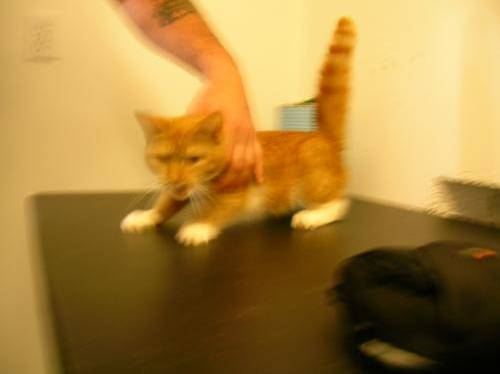

In [27]:
print(Y[0])
Image(filename=imagePaths[0])

Видно, что классом 1 у нас занумерованы коты (кошки).

Обучаем первый базовый классификатор - бэггинг деревьев принятия решений

In [28]:


tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=80)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=13, #количество деревьев
                            random_state=80)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=80),
                  n_estimators=13, random_state=80)

In [29]:
#Теперь обучим модель почти-разделяющий гиперплосоксти.
svm = LinearSVC(random_state = 80, C = 1.25)
svm.fit(trainData, Y)

LinearSVC(C=1.25, random_state=80)

In [30]:
# И наконец обучаем третий базовый алгоритм — случайный лес

forest = RandomForestClassifier(n_estimators=13, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=80)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=13, random_state=80)

In [31]:
#Задаем в качестве решающего метаалгоритма логистическую регрессию:


lr = LogisticRegression(solver='lbfgs', random_state=80)

In [32]:
#Обучаем метаалгоритм

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.25, random_state=80)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=80),
                                                  n_estimators=13,
                                                  random_state=80)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
          

In [33]:
#Оценка метамодели. Доля правильной классификации (Accuracy):

sclf.score(trainData, Y)


0.843

In [34]:
# Вычислим предсказания для объекта из папки test

singleImage = cv2.imread('/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/IZ_36_Ansamble_c&d_test/dog.1049.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

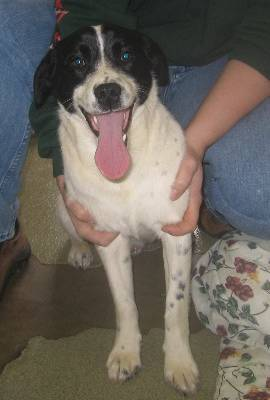

In [35]:
Image(filename='/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/IZ_36_Ansamble_c&d_test/dog.1049.jpg')

In [36]:
prediction

array([1])

In [37]:
sclf.predict_proba(histt2)

array([[0.40440071, 0.59559929]])

In [40]:

singleImage = cv2.imread('/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/IZ_36_Ansamble_c&d_test/dog.1028.jpg')
histt = extract_histogram(singleImage)
histt2_1028 = histt.reshape(1, -1)
prediction_1028 = sclf.predict(histt2_1028)

In [47]:
print(prediction_1028)
sclf.predict_proba(histt2_1028)

[0]


array([[0.28981088, 0.71018912]])

In [45]:

singleImage = cv2.imread('/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/IZ_36_Ansamble_c&d_test/dog.1011.jpg')
histt = extract_histogram(singleImage)
histt2_1011 = histt.reshape(1, -1)
prediction_1011 = sclf.predict(histt2_1011)

In [48]:
print(prediction_1011)
sclf.predict_proba(histt2_1011)

[0]


array([[0.58823011, 0.41176989]])

In [51]:

singleImage = cv2.imread('/Users/ekaterina/github_repos/ITMO_STUDY/ datasets/IZ_36_Ansamble_c&d_test/cat.1016.jpg')
histt = extract_histogram(singleImage)
histt2_1016 = histt.reshape(1, -1)
prediction_1016 = sclf.predict(histt2_1016)

In [52]:
print(prediction_1016)
sclf.predict_proba(histt2_1016)

[1]


array([[0.29553402, 0.70446598]])